In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, ZeroPadding2D, add
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/kaggle/Digit Recognizer/data/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/kaggle/Digit Recognizer/data/test.csv")

In [ ]:
# Check the data
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [ ]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
X_train = (train.iloc[:,1:].values).astype(float) # all pixel values
y_train = train.iloc[:,0].values.astype(int) # only labels i.e targets digits
X_test = test.values.astype(float)

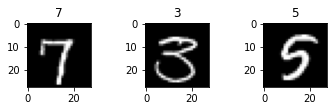

In [ ]:
#Convert train datset to (num_images, img_rows, img_cols) format 
X_train = X_train.reshape(-1, 28, 28)

for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

In [ ]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
#expand 1 more dimention as 1 for colour channel gray
X_train = X_train.reshape(-1, 28, 28,1)
X_train.shape

(42000, 28, 28, 1)

In [ ]:
X_test = X_test.reshape(-1, 28, 28,1)
X_test.shape

(28000, 28, 28, 1)

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(y_train, num_classes = 10)

In [ ]:
random_seed = 42
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

#Resnet

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
def identity_block(x, filter_mat, kernel_size=(3,3)):
  f1,f2,f3=filter_mat
  out=Conv2D(f1, (1,1))(x)
  out=BatchNormalization()(out)
  out=Activation('relu')(out)
  
  out=Conv2D(f2, kernel_size, padding='same')(out)
  out=BatchNormalization()(out)
  out=Activation('relu')(out)

  out=Conv2D(f3, (1,1))(out)
  out=BatchNormalization()(out)

  out=add([out,x])
  out=Activation('relu')(out)
  return out 

In [ ]:
def conv_block(x, filter_mat, kernel_size=(3,3)):
  f1,f2,f3=filter_mat

  out=Conv2D(f1, (1,1))(x)
  out=BatchNormalization()(out)
  out=Activation('relu')(out)

  out=Conv2D(f2,kernel_size,padding='same')(out)
  out=BatchNormalization()(out)
  out=Activation('relu')(out)

  out=Conv2D(f3,(1,1))(out)
  out=BatchNormalization()(out)

  x=Conv2D(f3,(1,1))(x)
  x=BatchNormalization()(x)

  out=add([out, x])
  out=Activation('relu')(out)
  return out

In [ ]:
inp = Input(shape=(28,28,1)) #默認image_data_format() == 'channels_last'，色彩通道要在最後
out = ZeroPadding2D((2,2))(inp)
out = Conv2D(1024,(3,3),strides=(2,2))(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = ZeroPadding2D(padding=(1, 1))(out)
out = MaxPooling2D((3,3),strides=(2,2))(out)

out = conv_block(out,[64,64,256])
out = identity_block(out,[64,64,256])
out = identity_block(out,[64,64,256])

out = conv_block(out,[128,128,512])
out = identity_block(out,[128,128,512])
out = identity_block(out,[128,128,512])
out = identity_block(out,[128,128,512])

out = conv_block(out,[256,256,1024])
out = identity_block(out,[256,256,1024])
out = identity_block(out,[256,256,1024])
out = identity_block(out,[256,256,1024])
out = identity_block(out,[256,256,1024])
out = identity_block(out,[256,256,1024])

out = conv_block(out,[512,512,2048])
out = identity_block(out,[512,512,2048])
out = identity_block(out,[512,512,2048])
out = identity_block(out,[512,512,2048])


out = AveragePooling2D((5,5))(out)
out = Flatten()(out)
out = Dense(10,activation='softmax')(out)

model = Model(inp,out)

In [ ]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
epochs = 100 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 100

In [ ]:
#提早終止
earlystop = EarlyStopping(monitor="val_accuracy", 
                          patience=15, 
                          verbose=1
                          )

In [ ]:
#學習率下降
reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_accuracy', 
                              patience=2, 
                              verbose=1)

In [ ]:
#儲存最佳模型
model_ckpt = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/kaggle/Digit Recognizer/model/best_md.h5", 
                             monitor="val_accuracy", 
                             save_best_only=True)

##一般(無增強)

In [ ]:
# Without data augmentation i obtained an accuracy of 0.98114
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, Y_val), verbose = 1,
                    callbacks=[model_ckpt,reduce_lr])

Epoch 1/30
378/378 [==============================] - 112s 296ms/step - loss: 0.3190 - accuracy: 0.9108 - val_loss: 8.1628 - val_accuracy: 0.1348
Epoch 2/30
378/378 [==============================] - 114s 301ms/step - loss: 0.0804 - accuracy: 0.9767 - val_loss: 0.5116 - val_accuracy: 0.8824
Epoch 3/30
378/378 [==============================] - 114s 300ms/step - loss: 0.0511 - accuracy: 0.9843 - val_loss: 0.0937 - val_accuracy: 0.9760
Epoch 4/30
378/378 [==============================] - 114s 301ms/step - loss: 0.0402 - accuracy: 0.9881 - val_loss: 0.0686 - val_accuracy: 0.9793
Epoch 5/30
378/378 [==============================] - 111s 293ms/step - loss: 0.0359 - accuracy: 0.9887 - val_loss: 0.2166 - val_accuracy: 0.9386
Epoch 6/30
378/378 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9897
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
378/378 [==============================] - 111s 293ms/step - loss: 0.0326 - accuracy: 0.9897 -

In [ ]:
def show_train_history(train_acc,test_acc):
    plt.plot(history.history[train_acc])
    plt.plot(history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend([f'train_{train_acc}', f'val_{train_acc}'], loc='upper left')
    plt.show()

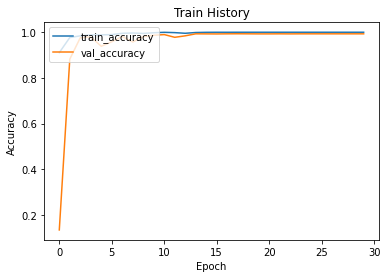

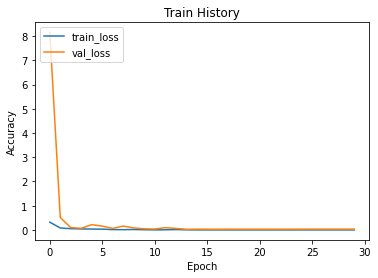

In [ ]:
show_train_history('accuracy','val_accuracy')
show_train_history('loss','val_loss')

##資料增強

https://zhuanlan.zhihu.com/p/30197320

https://www.easyaiforum.cn/static/template_page/Keras/augmentation.html

In [ ]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        data_format='channels_last')  


datagen.fit(X_train)

In [ ]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                    # steps_per_epoch=完成一次epoch需要跑多少個batch
                    steps_per_epoch=X_train.shape[0]//batch_size,
                    # validation_data = (X_val,Y_val),
                    # 測試集也增強
                    validation_data = datagen.flow(X_val,Y_val, batch_size=batch_size),
                    validation_steps = X_val.shape[0]//batch_size,
                    epochs = epochs,
                    verbose = 1,
                    callbacks=[earlystop,model_ckpt,reduce_lr])

Epoch 1/100
378/378 [==============================] - 276s 730ms/step - loss: 0.4829 - accuracy: 0.8528 - val_loss: 6.8382 - val_accuracy: 0.1121
Epoch 2/100
378/378 [==============================] - 264s 699ms/step - loss: 0.0886 - accuracy: 0.9735 - val_loss: 0.1558 - val_accuracy: 0.9571
Epoch 3/100
378/378 [==============================] - 248s 657ms/step - loss: 0.0717 - accuracy: 0.9785 - val_loss: 0.3205 - val_accuracy: 0.9140
Epoch 4/100
378/378 [==============================] - 263s 695ms/step - loss: 0.0588 - accuracy: 0.9824 - val_loss: 0.0722 - val_accuracy: 0.9790
Epoch 5/100
378/378 [==============================] - 247s 653ms/step - loss: 0.0543 - accuracy: 0.9843 - val_loss: 0.0925 - val_accuracy: 0.9733
Epoch 6/100
378/378 [==============================] - 261s 691ms/step - loss: 0.0522 - accuracy: 0.9843 - val_loss: 0.0491 - val_accuracy: 0.9860
Epoch 7/100
378/378 [==============================] - 248s 656ms/step - loss: 0.0461 - accuracy: 0.9866 - val_loss: 0

##讀回model預測

In [ ]:
best_model=load_model('/content/drive/My Drive/Colab Notebooks/kaggle/Digit Recognizer/model/best_md.h5')

In [ ]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
Y_prob=best_model.predict(X_val)
Y_pred=np.argmax(Y_prob,axis = 1)
Y_true=np.argmax(Y_val,axis = 1) 

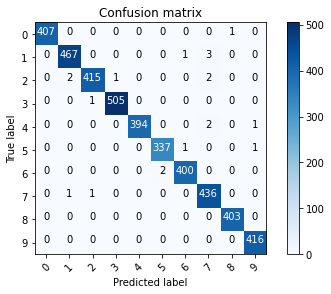

In [ ]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

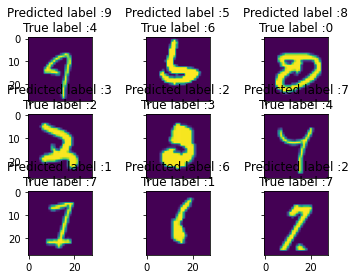

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred - Y_true != 0)

Y_pred_errors = Y_pred[errors]
Y_prob_errors = Y_prob[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 3
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_prob_errors_max = np.max(Y_prob_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_prob_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_prob_errors_max - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-9:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_errors, Y_true_errors)

#Predict

In [ ]:
results = best_model.predict(X_test)
# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("/content/drive/My Drive/Colab Notebooks/kaggle/Digit Recognizer/data/submit.csv",index=False)

#遷移學習(pending)
https://blog.csdn.net/xckkcxxck/article/details/78607068

In [ ]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras import backend as k
import cv2

In [ ]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/kaggle/Digit Recognizer/data/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/kaggle/Digit Recognizer/data/test.csv")
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype(int) # only labels i.e targets digits
X_test = test.values.astype('float32')

In [ ]:
k.clear_session()
X_train = X_train.reshape(-1, 28, 28,1)
X_test = X_test.reshape(-1, 28, 28,1)

In [ ]:
X_train=X_train[:10000]
X_test=X_test[:10000]

In [ ]:
#轉成VGG16需要的格式，要RGB通道
ishape = 224
X_train = [cv2.cvtColor(cv2.resize(i,(ishape,ishape)), cv2.COLOR_GRAY2BGR) for i in X_train]
X_train = np.array(X_train)
# X_train = np.concatenate([arr[np.newaxis] for arr in X_train]).astype('float32')
 
X_test  = [cv2.cvtColor(cv2.resize(i,(ishape,ishape)), cv2.COLOR_GRAY2BGR) for i in X_test]
X_test = np.array(X_test)
# X_test  = np.concatenate([arr[np.newaxis] for arr in X_test] ).astype('float32')

In [ ]:
X_train = X_train/255
X_test = X_test/255
 
Y_train = to_categorical(y_train, num_classes = 10)

In [ ]:
model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(ishape, ishape, 3))
for layers in model_vgg.layers:
    layers.trainable = False
 
model = Flatten()(model_vgg.output)
output = Dense(10, activation='softmax')(model)
model_vgg_pretrain = Model(inputs=model_vgg.input, outputs=output, name='vgg16_pretrain')
# model_vgg_mnist_pretrain.summary()
model_vgg_pretrain.compile(optimizer='adam', loss='categorical_crossentropy',
                                 metrics=['accuracy'])

In [ ]:
model_vgg_pretrain.fit(X_train, Y_train, validation_split=0.15,
                             epochs=200, batch_size=128)

Epoch 1/200
7/7 [==============================] - 7s 987ms/step - loss: 2.1873 - accuracy: 0.3541 - val_loss: 1.1841 - val_accuracy: 0.6200
Epoch 2/200
7/7 [==============================] - 3s 456ms/step - loss: 0.7422 - accuracy: 0.8176 - val_loss: 0.4510 - val_accuracy: 0.8533
Epoch 3/200
7/7 [==============================] - 3s 460ms/step - loss: 0.3096 - accuracy: 0.9271 - val_loss: 0.2753 - val_accuracy: 0.9400
Epoch 4/200
7/7 [==============================] - 3s 464ms/step - loss: 0.1837 - accuracy: 0.9612 - val_loss: 0.1710 - val_accuracy: 0.9600
Epoch 5/200
7/7 [==============================] - 3s 470ms/step - loss: 0.1217 - accuracy: 0.9788 - val_loss: 0.1469 - val_accuracy: 0.9600
Epoch 6/200
7/7 [==============================] - 3s 473ms/step - loss: 0.0853 - accuracy: 0.9871 - val_loss: 0.1275 - val_accuracy: 0.9733
Epoch 7/200
7/7 [==============================] - 3s 487ms/step - loss: 0.0655 - accuracy: 0.9918 - val_loss: 0.1226 - val_accuracy: 0.9667
Epoch 8/200
7